In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Import two datesets 
colnames = ["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE","FRST_DTE", "OLTV", 
            "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP","NUM_UNIT", "OCC_STAT", 
            "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG"]
Data_A = pd.read_table('D:/1-Intern/Project_1/2018Q1/Acquisition_2018Q1.txt', 
                       sep = '|', header = None, names = colnames)
colnames_P = ["LOAN_ID", "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat", 
              "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
              "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
              "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]
Data_P = pd.read_table('D:/1-Intern/Project_1/2018Q1/Performance_2018Q1.txt', 
                       sep = '|', header = None, names = colnames_P,low_memory=False)

In [3]:
# Convert string into datetime
from datetime import datetime 
Data_P['Monthly.Rpt.Prd']= [datetime.strptime(x, '%m/%d/%Y') for x in Data_P.loc[:, 'Monthly.Rpt.Prd']]

In [4]:
Data_P['Delq.Status_D90']= Data_P['Delq.Status'].replace(['1','2','X'], '0')
Data_P['Delq.Status_D90'] = Data_P['Delq.Status_D90'].replace(['3','4','5','6','7','8','9','10','11','12',
                                                     '13','14','15','16','17','18','19','20','21','22'], '1')
Data_P['Delq.Status_D90'].value_counts()

0    9318346
1      13567
Name: Delq.Status_D90, dtype: int64

In [5]:
Data_P['Delq.Status_D90']=pd.to_numeric(Data_P['Delq.Status_D90'])

In [6]:
# Start to create a outcome variable in model
Flag_90 = Data_P['Delq.Status_D90'].groupby(Data_P['LOAN_ID']).sum()
Flag_90 = pd.DataFrame(Flag_90)
Flag_90 = Flag_90.reset_index()
Flag_90['Delq.Status_D90'].value_counts()

0.0     423359
1.0        636
2.0        374
4.0        337
3.0        283
5.0        265
6.0        206
8.0        162
7.0        151
9.0        104
11.0        75
10.0        74
12.0        45
13.0        40
14.0        25
16.0        20
15.0        20
18.0        13
17.0        10
20.0         4
19.0         3
Name: Delq.Status_D90, dtype: int64

In [7]:
Flag_90['Delq.Status_D90']= Flag_90.loc[:,'Delq.Status_D90'].replace([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 1)

In [8]:
Flag_90['Delq.Status_D90'].value_counts()

0.0    423359
1.0      2847
Name: Delq.Status_D90, dtype: int64

In [9]:
df = pd.merge(Data_A, Flag_90, on = 'LOAN_ID')

In [10]:
#Date exploration - Predictor Variables
## 1: usually 'Seller.Name' is not related to model, so drop it.
df = df.drop(columns = 'Seller.Name')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426206 entries, 0 to 426205
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   LOAN_ID          426206 non-null  int64  
 1   ORIG_CHN         426206 non-null  object 
 2   ORIG_RT          426206 non-null  float64
 3   ORIG_AMT         426206 non-null  int64  
 4   ORIG_TRM         426206 non-null  int64  
 5   ORIG_DTE         426206 non-null  object 
 6   FRST_DTE         426206 non-null  object 
 7   OLTV             426206 non-null  int64  
 8   OCLTV            426205 non-null  float64
 9   NUM_BO           426206 non-null  int64  
 10  DTI              426095 non-null  float64
 11  CSCORE_B         425870 non-null  float64
 12  FTHB_FLG         426206 non-null  object 
 13  PURPOSE          426206 non-null  object 
 14  PROP_TYP         426206 non-null  object 
 15  NUM_UNIT         426206 non-null  int64  
 16  OCC_STAT         426206 non-null  obje

In [16]:
# Browse dataset
df.head(10)

,LOAN_ID,ORIG_CHN,ORIG_RT,ORIG_AMT,ORIG_TRM,ORIG_DTE,FRST_DTE,OLTV,OCLTV,NUM_BO,...,NUM_UNIT,OCC_STAT,STATE,ZIP_3,MI_PCT,Product.Type,CSCORE_C,MI_TYPE,RELOCATION_FLG,Delq.Status_D90
0,100001040173,R,4.250,453000,360,01/2018,03/2018,65,65.0,1,...,1,P,OH,430,NaN,FRM,NaN,NaN,N,0.0
1,100002370993,C,4.250,266000,360,01/2018,03/2018,80,80.0,2,...,1,P,IN,467,NaN,FRM,793.0,NaN,N,0.0
2,100005405807,R,3.990,233000,360,12/2017,01/2018,79,79.0,2,...,1,P,CA,936,NaN,FRM,665.0,NaN,N,0.0
3,100008071646,R,4.250,184000,360,01/2018,03/2018,80,80.0,1,...,1,P,FL,336,NaN,FRM,NaN,NaN,N,0.0
4,100010739040,R,4.250,242000,360,02/2018,04/2018,49,49.0,1,...,1,P,CA,906,NaN,FRM,NaN,NaN,N,0.0
5,100012691523,R,5.375,180000,360,01/2018,03/2018,80,80.0,1,...,1,P,OK,730,NaN,FRM,NaN,NaN,N,0.0
6,100020244091,R,4.875,140000,360,01/2018,03/2018,39,39.0,2,...,1,P,PA,189,NaN,FRM,782.0,NaN,N,0.0
7,100020295408,R,4.875,150000,360,02/2018,04/2018,69,69.0,1,...,1,P,TX,750,NaN,FRM,NaN,NaN,N,0.0
8,100021639708,R,3.990,227000,360,01/2018,03/2018,80,80.0,1,...,1,P,CO,809,NaN,FRM,NaN,NaN,N,0.0
9,100022479643,C,4.000,200000,360,11/2017,01/2018,80,80.0,1,...,1,P,MD,210,NaN,FRM,NaN,NaN,N,0.0


In [ ]:
#Show summary stat
df.describe()

In [28]:
# Count missing values by column 
df.isnull().sum()

LOAN_ID                 0
ORIG_CHN                0
ORIG_RT                 0
ORIG_AMT                0
ORIG_TRM                0
ORIG_DTE                0
FRST_DTE                0
OLTV                    0
OCLTV                   1
NUM_BO                  0
DTI                     0
CSCORE_B              336
FTHB_FLG                0
PURPOSE                 0
PROP_TYP                0
NUM_UNIT                0
OCC_STAT                0
STATE                   0
ZIP_3                   0
MI_PCT             312106
Product.Type            0
CSCORE_C           235423
MI_TYPE            312106
RELOCATION_FLG          0
Delq.Status_D90         0
Credit_Score            0
dtype: int64

In [11]:
df['Credit_Score']=df[['CSCORE_B','CSCORE_C']].min(axis=1)

In [12]:
df['DTI']=df['DTI'].fillna(df['DTI'].median())

In [13]:
df['Credit_Score']=df['Credit_Score'].fillna(df['Credit_Score'].median())

In [14]:
df.columns

Index(['LOAN_ID', 'ORIG_CHN', 'ORIG_RT', 'ORIG_AMT', 'ORIG_TRM', 'ORIG_DTE',
       'FRST_DTE', 'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLG',
       'PURPOSE', 'PROP_TYP', 'NUM_UNIT', 'OCC_STAT', 'STATE', 'ZIP_3',
       'MI_PCT', 'Product.Type', 'CSCORE_C', 'MI_TYPE', 'RELOCATION_FLG',
       'Delq.Status_D90', 'Credit_Score'],
      dtype='object')

In [15]:
# Explore Data 
## Numeric Variables
continous_cols = ['ORIG_RT', 'ORIG_AMT','OLTV','Credit_Score','NUM_UNIT']

In [16]:
X= df[continous_cols]
y= df['Delq.Status_D90']

In [17]:
#Logistic Regression model using sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [19]:
from sklearn.linear_model import LogisticRegressionCV
weights = {0:1.0, 1:100.0}
model = LogisticRegressionCV(10,class_weight=weights)
model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight={0: 1.0, 1: 100.0}, cv=None,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [20]:
# Make prediction on the training data
y_train_pred = model.predict(X_train)
p_train_pred = model.predict_proba(X_train)[:,1]

In [21]:
# Make predictions on test data
y_test_pred = model.predict(X_test)
p_test_pred = model.predict_proba(X_test)[:,1]

In [22]:
#Calculate the metric scores for the model
# Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [23]:
import pandas as pd
# Helper method to print metric scores
def get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, p_train_pred),
                    accuracy_score(y_train, p_train_pred>threshold),
                    precision_score(y_train, p_train_pred>threshold),
                    recall_score(y_train, p_train_pred>threshold),
                    f1_score(y_train, p_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, p_test_pred),
                    accuracy_score(y_test, p_test_pred>threshold),
                    precision_score(y_test, p_test_pred>threshold),
                    recall_score(y_test, p_test_pred>threshold),
                    f1_score(y_test, p_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred):
    roc_auc_train = roc_auc_score(y_train, p_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, p_train_pred)

    roc_auc_test = roc_auc_score(y_test, p_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, p_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

              train      test
metrics                      
AUC        0.732232  0.737732
Accuracy   0.842758  0.844173
Precision  0.019931  0.020613
Recall     0.471264  0.466667
f1-score   0.038245  0.039482


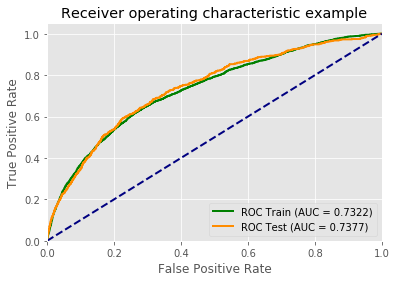

In [25]:
# print model results
get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

Text(0.5, 257.44, 'Predicted label')

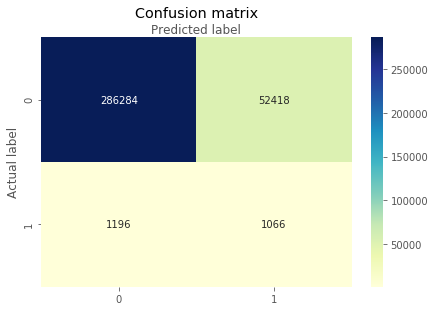

In [26]:
# Make prediction on the training data
y_train_pred_1 = model.predict(X_train)
p_train_pred_1 = model.predict_proba(X_train)

# Make predictions on test data
y_test_pred_1 = model.predict(X_test)
p_test_pred_1 = model.predict_proba(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred_1)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
coefficients

,0,0
0,ORIG_RT,0.193992
1,ORIG_AMT,-0.000001
2,OLTV,0.039681
3,Credit_Score,-0.005852
4,NUM_UNIT,0.023160


In [29]:
import numpy as np
import statsmodels.api as sm

In [30]:
model_s = sm.Logit(y, X)
result_s = model_s.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.035976
         Iterations 10


In [31]:
result_s.params

ORIG_RT         8.646688e-01
ORIG_AMT       -5.434188e-07
OLTV            2.383709e-02
Credit_Score   -1.470481e-02
NUM_UNIT        2.198357e-02
dtype: float64

In [33]:
# confustion matrix 
result_s.pred_table()

array([[423359.,      0.],
       [  2847.,      0.]])

In [34]:
result_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Delq.Status_D90   No. Observations:               426206
Model:                          Logit   Df Residuals:                   426201
Method:                           MLE   Df Model:                            4
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                  0.1032
Time:                        10:37:33   Log-Likelihood:                -15333.
converged:                       True   LL-Null:                       -17097.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ORIG_RT          0.8647      0.030     28.445      0.000       0.805       0.924
ORIG_AMT     -5.434e-07   1.64e-07     -3.312      0.001   -8.65e-07   -2.22e-07
OLTV             0.0238      0.001     16.726      0.000       0.021       0.027
Credit_Score    -0.0147      0.000    -66.023      0.000      -0.015      -0.014
NUM_UNIT         0.0220      0.081      0.270      0.787      -0.137       0.181
================================================================================
"""